## $H \to \gamma \gamma$ Fit

This is an example of fitting the 2-photon invariant mass to determine the number of Higgs signal events.

We have a data set consists of ~ 30000 di-photon invariant mass values from a tetx file (**Hgg.txt**) which should be in the current directory. 

We perform a binned maximum likelihood fit (for reducing the CPU time) using RooFit.  

#### 1. Reading Input data set

In [1]:
TTree tree("tree","tree");
int nevt = tree.ReadFile("Hgg.txt","x");
if (nevt <= 0) {
    Error("fitHgg","Error reading data from input file ");
}
std::cout << "Read " << nevt << " from the file " << std::endl;

Read 30770 from the file 


#### 2. Model creation

We make now the RooFit model using the RooWorkspace Factory. We assume a Gaussian distribution for the signal and a double  exponential distribution for the background as following: 

$$ P(x | \mu , \nu ) = n_{sig} \times G(x | M , \sigma) + n_{bkg} \times E(x|a_1,a_2)$$

where $G (x | M , \sigma)$ is the Gaussian distribution for the signal and $E(x|a_1,a_2)$ is the exponential distribution describing the background. 

$$E(x|a_1,a_2) = \frac{ e^{( - a1 * x/100 - a2 * (x/100)^2 )}}{\int e^{-(.....)} dx }$$ 

In [2]:
   RooWorkspace w("w");
   w.factory("x[110,160]");  // invariant mass
   
   w.factory("nbackground[10000, 0, 10000]");
   //w.factory("Exponential::z1(x, a1[-1,-10,0])");
   w.var("nbackground")->setVal(nevt);
   w.var("nbackground")->setMin(0.1*nevt);
   w.var("nbackground")->setMax(10*nevt);

   // create exponential model as two components
   w.factory("a1[ 7.5, -500, 500]");
   w.factory("a2[-1.5, -500, 500]");
   //w.factory("cexpr::z('-(a1*x/100. + a2*(x*x/100000.))', a1, a2, x)");
   w.factory("expr::z('-(a1*x/100. + a2*(x/100.)^2)', a1, a2, x)");
   w.factory("Exponential::bmodel(z, 1)");

   // signal model   
   w.factory("nsignal[100, 0.0, 1000.0]");
   //w.factory("mass[%f, %f, %f]' % (massguess, massmin, massmax))
   w.factory("mass[130, 110, 150]");
   w.factory("width[1, 0.5, 5]");
   w.factory("Gaussian::smodel(x, mass, width)");
   RooAbsPdf * smodel = w.pdf("smodel");

   w.factory("SUM::model(nbackground*bmodel, nsignal*smodel)");
   RooAbsPdf * model = w.pdf("model");
   RooRealVar * x = w.var("x");


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
w.Print();


RooWorkspace(w) w contents

variables
---------
(a1,a2,mass,nbackground,nsignal,width,x)

p.d.f.s
-------
RooExponential::bmodel[ x=z c=1 ] = 0.000616625
RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000610556
RooGaussian::smodel[ x=x mean=mass sigma=width ] = 3.72665e-06

functions
--------
RooFormulaVar::z[ actualVars=(a1,a2,x) formula="-(a1*x/100.+a2*(x/100.)^2)" ] = -7.39125



##### Creation of RooFit data set

We create now the RooFit data set importing the data from the ROOT tree.
We import also the data set in the workspace.
We now bin the data in an histogram and we create a RooFit data set from the histogram with 100 bins from 110 to 160. 

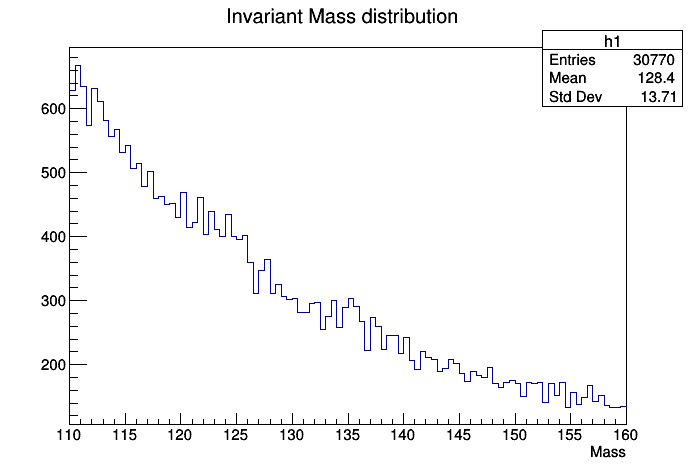

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [4]:
auto h1 = new TH1D("h1","Invariant Mass distribution;Mass;",100,110,160);
tree.Draw("x >> h1");
h1->Draw(); gPad->Draw();

In [5]:
RooDataHist data("data","data",*w.var("x"),h1);
w.import(data);

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data): fit range of variable x expanded to nearest bin boundaries: [110,160] --> [110,160]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data


In [6]:
RooFitResult * r = nullptr;
RooPlot * plot = nullptr;

In [7]:
plot = w.var("x")->frame();
data.plotOn(plot);

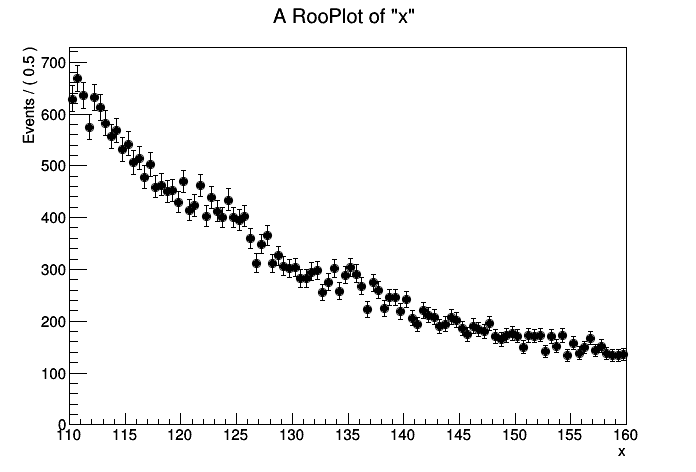

In [8]:
plot->Draw(); gPad->Draw();

### 3 Fit to the data

The binned maximum likelihood fit is perfomed using RooFit to the binned data set. 
Minuit2 is used as minimization engine. Note that we use a special option, RooFit::Offset(true) which subtract from the likelihood an offset to mitigate the numerical precision when computing the negative log-likelihood function.

In [9]:
r = model->fitTo(data, RooFit::Minimizer("Minuit2"),RooFit::Save(true), RooFit::Offset(true));

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (bmodel,smodel)
Minuit2Minimizer: Minimize with max-calls 3000 convergence for edm < 1 strategy 1
[#1] INFO:Minization -- RooNLLVar::evaluatePartition(nll_model_data) first = 0 last = 100 Likelihood offset now set to -156452
MnSeedGenerator: for initial parameters FCN = 0
MnSeedGenerator: Initial state:   - FCN =                0 Edm =      13041.3 NCalls =     29
MnSeedGenerator: Negative G2 found - new state:   - FCN =  -383.2116896473 Edm =      1468

Info in <Minuit2>: Minuit2Minimizer::Hesse : Hesse is valid - matrix is accurate


#### 4. Plot of the fit result over the data

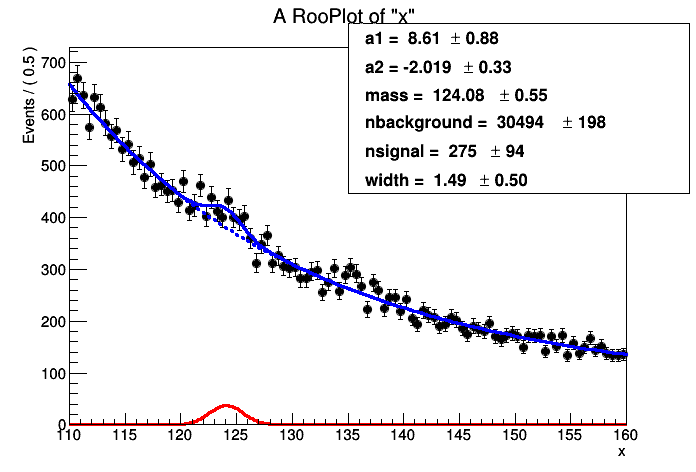

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bmodel)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: (z)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (smodel)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bmodel_Int[x]) using numeric integrator RooIntegrator1D to calculate Int(x)


In [10]:

model->plotOn(plot);
model->plotOn(plot, RooFit::Components("bmodel"),RooFit::LineStyle(kDashed));
model->plotOn(plot, RooFit::Components("smodel"),RooFit::LineColor(kRed));
model->paramOn(plot);

plot->Draw();
gPad->Draw();

#### 5. Create RooStats model for statistical calculation
Before saving the workspace we create the RooStats model config object which is needed for the RooStats tools.

In [11]:
RooStats::ModelConfig mc("ModelConfig",&w);
mc.SetPdf(*w.pdf("model"));
mc.SetParametersOfInterest(*w.var("nsignal"));
mc.SetObservables(*w.var("x"));
// define set of nuisance parameters
w.defineSet("nuisParams","a1,a2,nbackground");

mc.SetNuisanceParameters(*w.set("nuisParams"));
mc.Print();


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000350859



We want to semplify the H->gg model (for speeding-up ) the RooStats calculations, by assuming that the mass and the sigma of the signal are known and do not vary in the fits. We set them to constant

In [12]:
w.var("mass")->setConstant(true);
w.var("width")->setConstant(true);
w.import(mc);

In [13]:
w.writeToFile("HiggsBinModel.root",true);
w.Print();


RooWorkspace(w) w contents

variables
---------
(a1,a2,mass,nbackground,nsignal,width,x)

p.d.f.s
-------
RooExponential::bmodel[ x=z c=1 ] = 0.000354025
RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000350859
RooGaussian::smodel[ x=x mean=mass sigma=width ] = 1.8233e-12

functions
--------
RooFormulaVar::z[ actualVars=(a1,a2,x) formula="-(a1*x/100.+a2*(x/100.)^2)" ] = -7.94614

datasets
--------
RooDataHist::data(x)

named sets
----------
ModelConfig_NuisParams:(a1,a2,nbackground)
ModelConfig_Observables:(x)
ModelConfig_POI:(nsignal)
nuisParams:(a1,a2,nbackground)

generic objects
---------------
RooStats::ModelConfig::ModelConfig

